# Sound Field Analysis

[return to main page](index.ipynb)

## Preparations

In [2]:
import tools
import numpy as np
import sounddevice as sd  # for playback
import soundfile as sf  # for reading a soundfile
from scipy import signal

# remove "inline" to get a separate plotting window:
%matplotlib inline  
import matplotlib.pyplot as plt

# Linear Microphone Arrays


### Spatio-Temporal Fourier Spectrum and Plane Wave Decomposition

The [Spatio-Temporal Fourier Spectrum](linear_systems_II.ipynb#The-Spatial-Transfer-Function) of a Sound Field reads

$$ \tilde P(\mathbf k, \omega) = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} P(x,y,z,\omega) e^{+jk_x x} e^{+jk_y y} e^{+jk_z z} \,\mathrm d x\,\mathrm d y\,\mathrm d z$$

We already got to know the temporal spectrum of a [plane wave](physics_of_sound_I-solutions.ipynb#Plane-Wave) with a direction of propagation $\mathbf n_{\mathrm {pw}}$ which reads

$$P_{pw}(\mathbf x, \omega) = \mathrm{exp}\left(-j\frac{\omega}{c} \mathbf n_{\mathrm {pw}} \cdot \mathbf x \right) = \mathrm{exp}\left(-j\frac{\omega}{c} (n_{\mathrm {pw},x} \cdot x + n_{\mathrm {pw},y} \cdot y + n_{\mathrm {pw},z} \cdot z) \right) \,. $$

We also derived its [Spatio-Temporal Fourier Transform](linear_systems_II.ipynb#Spatial-Temporal-Fourier-Transform-of-a-Plane-Wave)

$$
\tilde P_{pw}(\mathbf k, \omega) = 
    2\pi \delta\left(k_x-\frac{\omega}{c} n_{\mathrm {pw},x}\right) \cdot
    2\pi \delta\left(k_y-\frac{\omega}{c} n_{\mathrm {pw},y}\right) \cdot
    2\pi \delta\left(k_z-\frac{\omega}{c} n_{\mathrm {pw},z}\right)
    =
    (2\pi)^3 \delta\left(\mathbf k -\frac{\omega}{c} \mathbf n_{\mathrm {pw}}\right)
$$

For a general sound field $P(\mathbf x,\omega)$, we now know that the value of its Spatio-Temporal Fourier Transform $\tilde P(\mathbf k, \omega)$ at $\mathbf k = \frac{\omega}{c} \mathbf n_{\mathrm {pw}}$ corresponds to the amplitude of the plane wave propagation in the direction of $\mathbf n_{\mathrm {pw}}$. This can be straightforwardly used to compute the so-called plane wave composition of the sound field. It reads

$$
\bar P(\mathbf n_{\mathrm {pw}}) = \tilde P(\mathbf k, \omega)|_{\mathbf k = \frac{\omega}{c} \mathbf n_{\mathrm {pw}}}
$$

If we know $\tilde P(\mathbf k, \omega)$ then we automatically know $\bar P(\mathbf n_{\mathrm {pw}})$. 

## Delay-and-Sum Beamformer

A linear microphone captures the sound field along a line in space. Let's assume, we have defined our coordinate system such that this line is $x$-axis, i.e. $\mathbf x = [x, 0, 0]^T$. The sound field on the $x$-axis is known by the measurement of the array, we can compute the spatial Fourier transform w.r.t $x$

$$ \tilde P(k_x, 0, 0, \omega) = \int_{-\infty}^{\infty} P(x,0,0,\omega) e^{+jk_x x}\,\mathrm d x$$


In [3]:
# theoretical result of a delay-and-sum beamformer for single plane wave
def compute_dsb_beampattern(theta, theta_pw, omega, dx, M, c=343):
    X_pw = np.zeros(shape=(len(omega), len(theta_pw)), dtype=complex)
    for n, k in enumerate(omega/c):
        for dm in np.arange(M)*dx:
            X_pw[n, :] += np.exp(-1j * k * dm * (np.cos(theta_pw) - np.cos(theta)))
            
    return X_pw/M

# it's just plotting the pattern
def plot_dsb_beampattern(X_pw, theta_pw, omega):
    
    X_pw = X_pw / np.max(np.abs(X_pw[:]))
    
    plt.figure(figsize=(10,10))
    plt.pcolormesh(theta_pw/np.pi*180, omega/(2*np.pi), 20*np.log10(np.abs(X_pw)), cmap='viridis')
    plt.colormaps()
    plt.ylim([0, 8000])
    plt.xlim([0, 180])
    plt.colorbar()
    plt.clim([-60,0])

    plt.xlabel(r'$\theta_{pw}$ in deg')
    plt.ylabel('$f$ in Hz')
    plt.title(r'$|\bar{P}(\theta, \theta_{pw}, \omega)|$ in dB')

### Infinite, Discrete Array

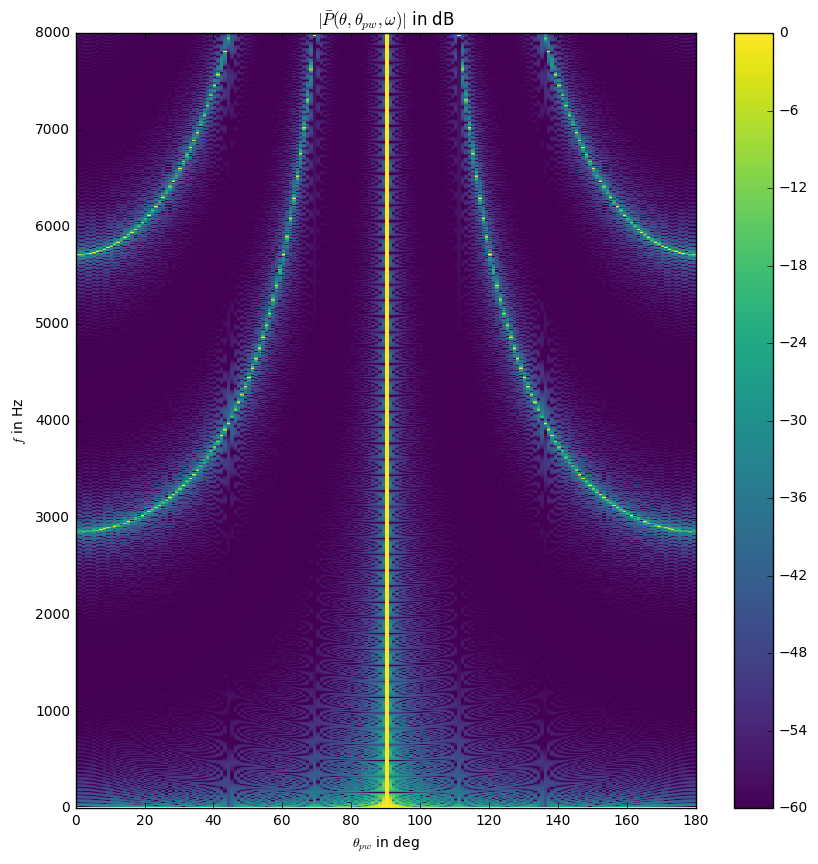

In [4]:
omega = 2*np.pi * np.linspace(20, 8000, 1000)  # evaluated angular frequencies
theta_pw = np.linspace(0, np.pi, 181)  # evaluated incident plane waves
dx = 0.12 # distance between microphones
M = 1000  # total number of microphones (approx. infinite)
theta = np.pi/2  # steering direction

X_pw = compute_dsb_beampattern(theta, theta_pw, omega, dx, M)
plot_dsb_beampattern(X_pw, theta_pw, omega)

### Truncated, Discrete Array

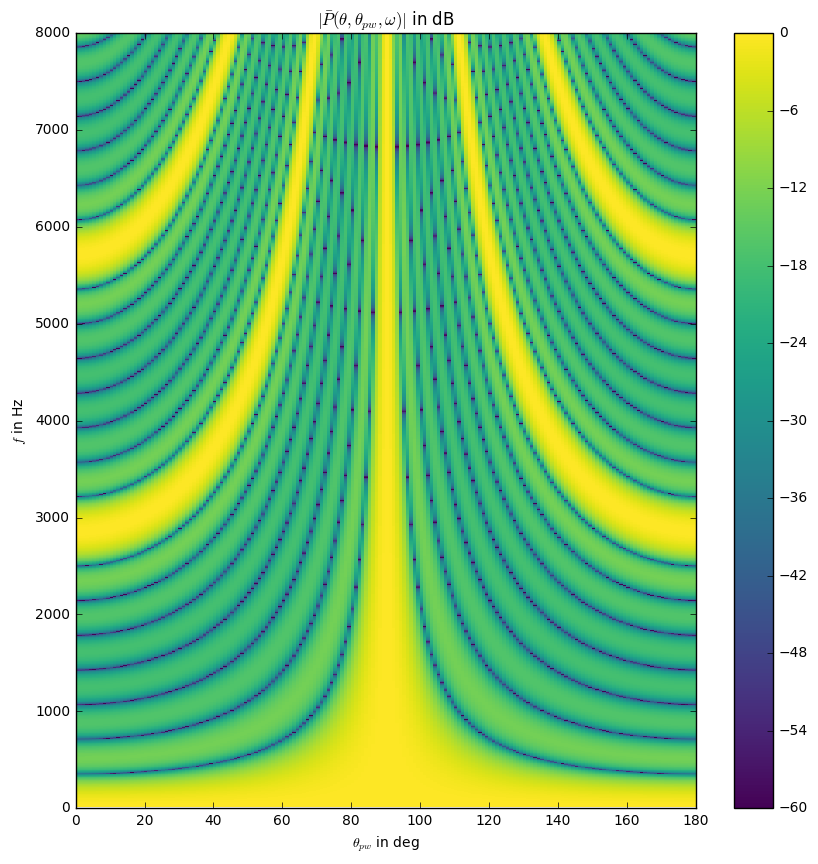

In [5]:
omega = 2*np.pi * np.linspace(20, 8000, 1000)  # evaluated angular frequencies
theta_pw = np.linspace(0, np.pi, 181)  # evaluated incident plane waves
dx = 0.12 # distance between microphones
M = 8 # total number of microphones (approx. infinite)
theta = np.pi/2  # steering direction

X_pw = compute_dsb_beampattern(theta, theta_pw, omega, dx, M)
plot_dsb_beampattern(X_pw, theta_pw, omega)

### A real Array in a real Room

#### Measurements (Optional)

A long as you don't a sound card with 8 input channels and 2 output channels together with 8 microphones and 2 loudspeaker, executing the following code doesn't make much sense. Check the next section to load the measurement from a .wav-file.

In [ ]:
# check id of sound card
sd.query_devices()

In [6]:
sd.default.device = 0  # HAMMERFALL DSP
input_channels = np.arange(9,17)  # all 8 ADAT input channels

[x_target, fs] = sf.read('data/xmas.wav')  # target sound
x_target *= 0.01
x_noise = 0.007*np.random.randn(len(x_target))  # gaussian noise as masker
x_mix = np.column_stack((x_target, x_noise))

# record signal 1
x_rec_one = sd.playrec(x_noise,
                   samplerate=fs,
                   input_mapping=input_channels, 
                   output_mapping=1, 
                   blocking=True)

# record signal 2
x_rec_two = sd.playrec(x_noise, 
                   samplerate=fs,
                   input_mapping=input_channels, 
                   output_mapping=2, 
                   blocking=True)

# record mix
x_rec_mix = sd.playrec(x_mix, 
                   samplerate=fs,
                   input_mapping=input_channels, 
                   output_mapping=[1,2], 
                   blocking=True)

# save files
sf.write(x_rec_one, 'data/sfa/noise_rec_one.wav', fs)     
sf.write(x_rec_two, 'data/sfa/noise_rec_two.wav', fs)
sf.write(x_rec_mix, 'data/sfa/xmas_noise_rec.wav', fs)

#### Load the Files 

In [9]:
x_rec_one, fs = sf.read('data/sfa/noise_rec_one.wav')
x_rec_two, _ = sf.read('data/sfa/noise_rec_two.wav')
x_rec_mix, _ = sf.read('data/sfa/xmas_noise_rec.wav')

n, _ = np.shape(x_rec_one)

#### Beamforming

A function for DSB-Beamforming with the recorded signals

In [7]:
def dsb_beamforming(x_rec, theta, dx, M, nfft, c=343):
    # get temporal spectrum (DFT)
    X_rec = np.fft.rfft(x_rec, n=nfft, axis=0)
    omega = 2*np.pi*np.fft.rfftfreq(nfft, 1/fs)
    
    # get plane wave decomposition using DSB
    X_pw = np.zeros((len(omega),len(theta)), dtype='complex')
    for tdx, th in enumerate(theta):
        for ddx, dm in enumerate(np.arange(M)*dx):
            X_pw[:,tdx] += X_rec[:,ddx]*np.exp(-1j*omega/c*dm*np.cos(th))
    
    return X_pw/M, omega

For the first loudspeaker

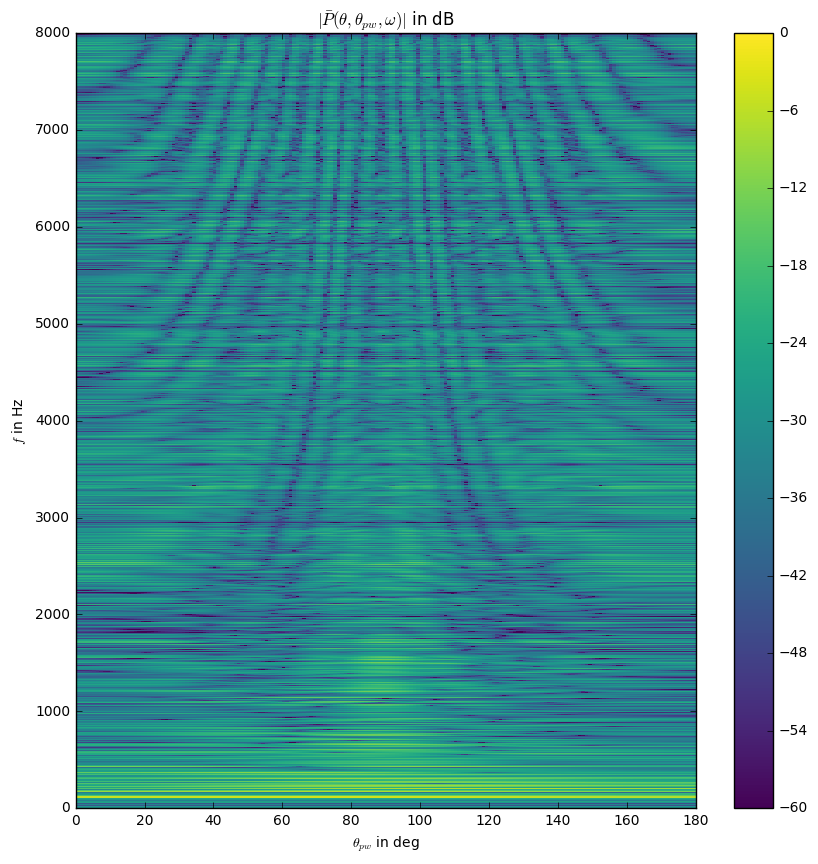

In [10]:
dx = 0.12 # distance between microphones
M = 8 # total number of microphones (approx. infinite)
theta = np.linspace(0, np.pi, 181) # steering directions

X_pw_one, omega = dsb_beamforming(x_rec_one, theta, dx, M, 2*n)
plot_dsb_beampattern(X_pw_one, theta, omega)

..., for the second loudspeaker

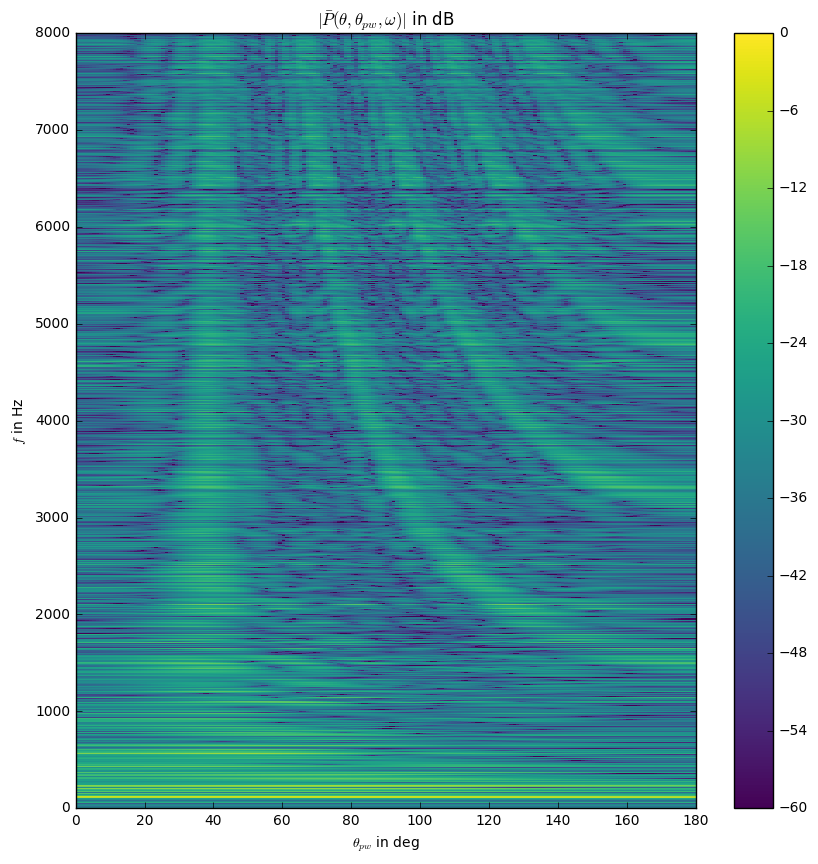

In [11]:
dx = 0.12 # distance between microphones
M = 8 # total number of microphones (approx. infinite)
theta = np.linspace(0, np.pi, 181) # steering directions

X_pw_two, omega = dsb_beamforming(x_rec_two, theta, dx, M, 2*n)
plot_dsb_beampattern(X_pw_two, theta, omega)

..., and the mix.

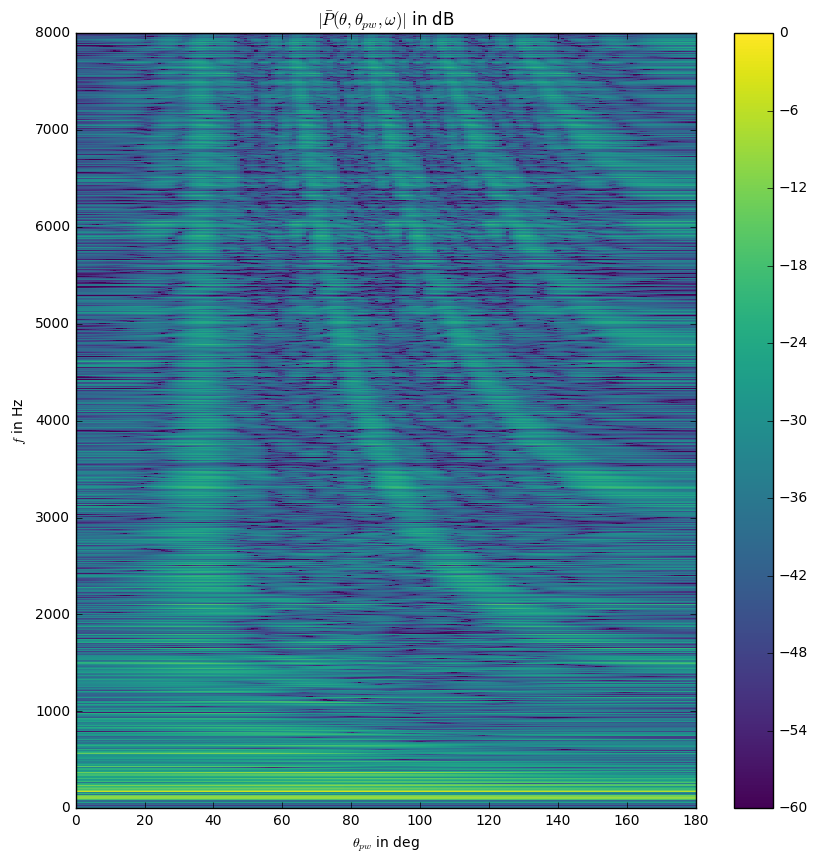

In [14]:
dx = 0.12 # distance between microphones
M = 8 # total number of microphones (approx. infinite)
theta = np.linspace(0, np.pi, 181) # steering directions

X_pw_mix, omega = dsb_beamforming(x_rec_mix, theta, dx, M, 2*n)
plot_dsb_beampattern(X_pw_mix, theta, omega)

What happens, if the switch off every second microphone? Why?

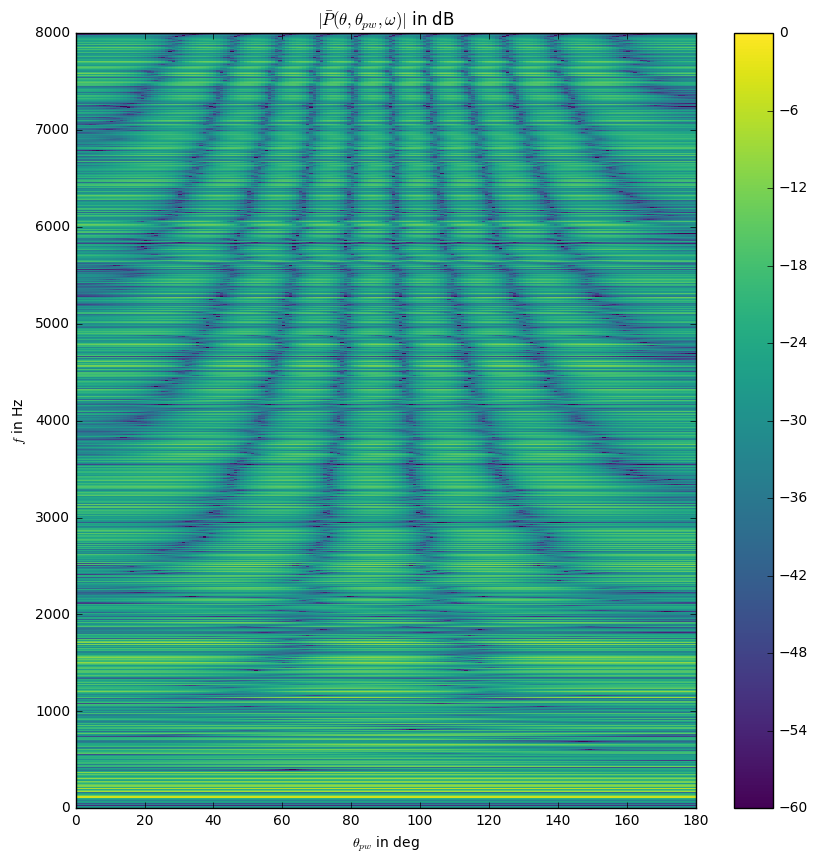

In [13]:
dx = 0.12 # distance between microphones
M = 8 # total number of microphones (approx. infinite)
theta = np.linspace(0, np.pi, 181) # steering directions

x_rec_one_sub = x_rec_one
x_rec_one_sub[:,0:1] = 0
x_rec_one_sub[:,6:7] = 0

X_pw_one_sub, omega = dsb_beamforming(x_rec_one_sub, theta, dx, M, 2*n)
plot_dsb_beampattern(X_pw_one_sub, theta, omega)

#### Listen

In [15]:
x_pw_one = np.fft.irfft(X_pw_one, axis=0)
x_pw_two = np.fft.irfft(X_pw_two, axis=0)
x_pw_mix = np.fft.irfft(X_pw_mix, axis=0)

In [18]:
direction = 45

sd.play(0.05*x_pw_mix[:,direction], 
        samplerate=fs,
        mapping=1, 
        blocking=True)

In [ ]:
np.shape(x_rec_one_sub[:,0:7:2])

<p xmlns:dct="http://purl.org/dc/terms/">
  <a rel="license"
     href="http://creativecommons.org/publicdomain/zero/1.0/">
    <img src="http://i.creativecommons.org/p/zero/1.0/88x31.png" style="border-style: none;" alt="CC0" />
  </a>
  <br />
  To the extent possible under law,
  <span rel="dct:publisher" resource="[_:publisher]">the person who associated CC0</span>
  with this work has waived all copyright and related or neighboring
  rights to this work.
</p>